# Сборный проект

# Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


## Описание данных
-   Name — название игры
-	Platform — платформа
-	Year_of_Release — год выпуска
-	Genre — жанр игры
-	NA_sales — продажи в Северной Америке (миллионы проданных копий)
-	EU_sales — продажи в Европе (миллионы проданных копий)
-	JP_sales — продажи в Японии (миллионы проданных копий)
-	Other_sales — продажи в других странах (миллионы проданных копий)
-	Critic_Score — оценка критиков (максимум 100)
-	User_Score — оценка пользователей (максимум 10)
-	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
print('\n Количество дубликатов:', len(df.duplicated()) - len(df))


 Количество дубликатов: 0


In [5]:
#Количество пропусков в каждом столбце
print(df.isnull().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


In [6]:
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Critic_Score,8578,0.51
Rating,6766,0.40
User_Score,6701,0.40
Year_of_Release,269,0.02
Name,2,0.00
Genre,2,0.00
Platform,0,0.00
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00


В качестве исходных данных предоставлена таблица, состоящая из 11 колонок и 16715 строк. Названия столбцов не в едином формате, типы данных некоторых колонок не соответствуют значениям, также есть пропуски.

Пропуски в столбцах year_of_release, critic_score, user_score, относятся к категориальным пропускам, при более подробном рассмотрении подумаем как их заменить, но на данном этапе можно сказать что такие переменные лучше заменить на медиану, опираясь на прошлый опыт.
Пропуски в столбцах name, rating относятся к категориальным пропускам, которые в последующем мы заменим на пустые значения или на более подходящие по смыслу. 
Пропуски в имени могут быть из за ошибки выгрузки данных или могут быть просто случайными т.к таких пропусков 2, пропуски в рейтинге могут говорить о том, что данные игры не имеют ограничения , оставшиеся пропуски скорее всего появляются когда оценки критиков и пользователей ещё не выставлены, но если мы заменим их на медианное значение это не повлияет на результат и распределения

## Шаг 2. Подготовьте данные

-	Замените названия столбцов (приведите к нижнему регистру);
-	Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
-	Обработайте пропуски при необходимости:
-	Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
-	Опишите причины, которые могли привести к пропускам;
-	Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
-	Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.


In [7]:
# Приводим к нижнему регистру названия столбцов
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
#Оказалась что пропуски у этих столбцов совпадают. Заполнить их как-либо мы не в силах, поэтому их лучше отбросить.
df = df.dropna(subset=['name'])

In [10]:
# Пропусков в year_of_release не много - 1,6% всех данных. Заполнить их не прдставляется возможным, поэтому тоже их отбросим.
df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype('int')

In [11]:
#Пропусков в столбцах critic_score и user_score очень много и заполнить их также не представляется возможным, как и удалить. 
#Однако есть любопытные пропуски в user_score - 'tbd'.
df[df['user_score']=='tbd']['user_score']

119      tbd
301      tbd
520      tbd
645      tbd
718      tbd
        ... 
16695    tbd
16697    tbd
16698    tbd
16704    tbd
16706    tbd
Name: user_score, Length: 2376, dtype: object

In [12]:
# В столбце 'user_score', кроме пропусков и значений содержится значения "tbd" (to be defined), которые стоит заменить на NaN, 
#так как эта аббревиатура обозначает "Будет определено"

df.loc[df['user_score'] =='tbd','user_score'] = np.nan
df['user_score'] = pd.to_numeric(df['user_score'])

In [13]:
#Пропуски в столбцах critic_score и user_score заменим на -1, чтобы в дальнейшем можно было проводить анализ.
# В канале project преподаватель Алан Кабисов рекомендовыал делать именно так, потому что пропусков очень много 
# и их заполнение каким-либо значением может сместить наши оценки

df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)

In [14]:
print('Количество пропусков в столбце critic_score - {}'.format(df['critic_score'].isnull().sum()))
print('Количество пропусков в столбце user_score - {}'.format(df['user_score'].isnull().sum()))

Количество пропусков в столбце critic_score - 0
Количество пропусков в столбце user_score - 0


In [15]:
# также заменим тип данных в колонке critic_score на целочисленный.
df['critic_score'] = df['critic_score'].astype('int')

In [16]:
#В столбце rating заменим все пропуски на 'unknown', т.е. рейтинг неизвестный. Так сможем учесть эти данные 
#при дальнейшем анализе.

df['rating'] = df['rating'].fillna('unknown')

In [17]:
df.duplicated().sum()

0

In [18]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,unknown
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1,-1.0,unknown
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,unknown
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1,-1.0,unknown


In [19]:
# Добавим к исходной таблице столбец, в котором будет сумма продаж по всем регионам для каждой игры.
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38


Таким образом, мы сделали следующее:

- заменили названия столбцов
- заменили типы данных для удобствав у некоторых столбцов
- обработали пропущенные значения в названии игры (такие строчки в количестве 2 штук удалили, так как они не несут никакой смысловой нагрузки), оценке критиков и оценке пользователей (все пропущенные значения соответственно были промаркированы -1 ввиду того, что точным образом их обработать нельзя на данном этапе).
- Также пропущенные значения в рейтинге заменили на "unknown"

## Шаг 3. Проведите исследовательский анализ данных

-	Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
-	Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
-	Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
-	Не учитывайте в работе данные за предыдущие годы.
-	Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
-	Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
-	Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
-	Соотнесите выводы с продажами игр на других платформах.
-	Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?


### Выпущенные игры по годам

In [20]:
# с помощью сводной таблицы сгруппируем данные по годам и посчитаем количество выпущенных игр для каждого года
games_count = df.pivot_table(index='year_of_release', aggfunc={'name':'count'})
games_count.columns = ['counts_of_games']
#games_count

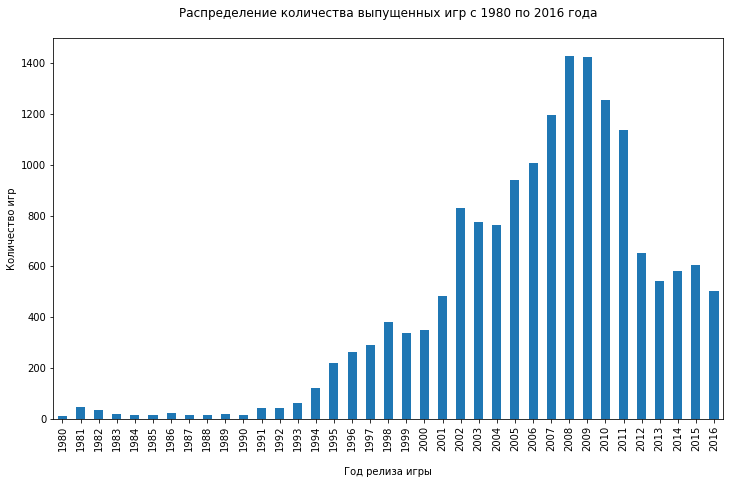

In [21]:
# построим график распределения количества выпущенных игр в течение интересующего нас отрезка времени
games_count.plot(y='counts_of_games', kind='bar', figsize=(12, 7), legend=False)
plt.title(label='Распределение количества выпущенных игр с 1980 по 2016 года\n')
plt.xlabel("\nГод релиза игры")
plt.ylabel("Количество игр")
plt.show()

Видим что произошел скачок в разработке игр после 1993 года, так продолжалось до 2009 года, после чего пошел спад и резкое падение в разработке в 2012 году.

Заметим, что больше всего игр было выпущено в период с 2005 по 2011 год.

Для нашего анализа данные за весь предоставленный период не нужны, а нужны только те, которые отражают тенденции последних лет. В данном случае это данные после 2011 года.

### Изменения продаж платформ

In [22]:
#Определим десять платформ с наибольшими суммарными продажами и построим гистограммы распределения продаж для каждой из 
#этих платформ.

platform_sales_sum = (df
                      .pivot_table(index=['platform'], aggfunc={'total_sales':sum})
                      .nlargest(10, columns='total_sales')
                     )
platform_sales_sum

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [23]:
# создадим новый датафрэйм отфильтрованный по топ-10 платформ:
platform_years = df.query('platform in @platform_sales_sum.index')
platform_years

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.00,0.00,-1,-1.0,unknown,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,-1,-1.0,unknown,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1,-1.0,unknown,0.01


In [24]:
#Построим гистограммы
# создаем список с названиями платформ:
platform_list = platform_years['platform'].unique()

In [25]:
# создаем список с временным диапазоном:
years_list = []
for i in range(1980, 2017):
    years_list.append(i)

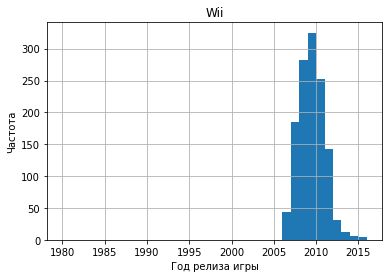

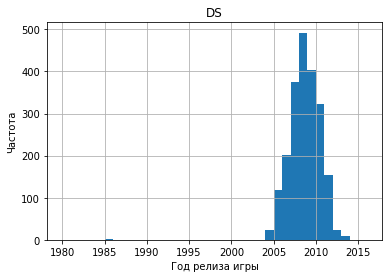

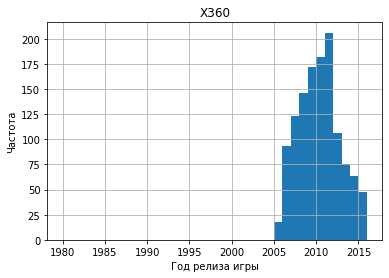

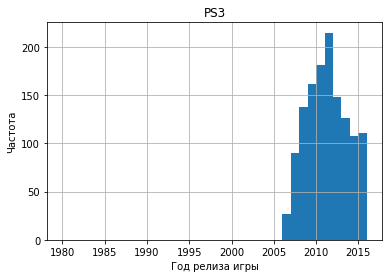

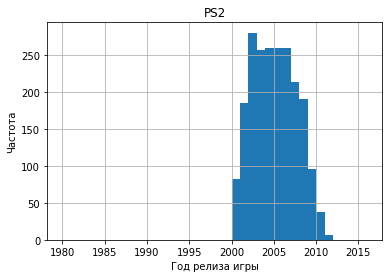

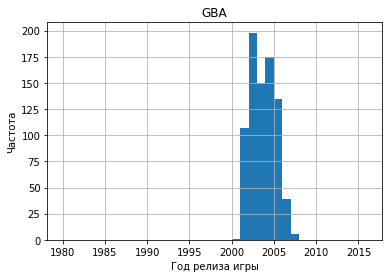

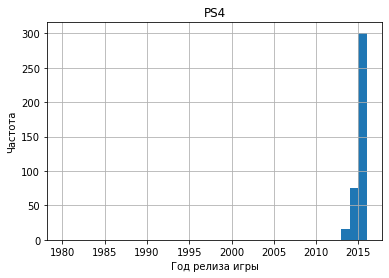

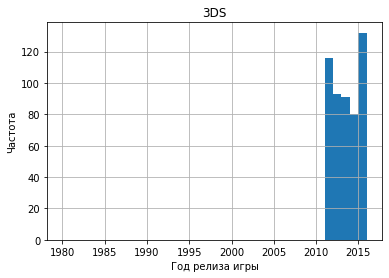

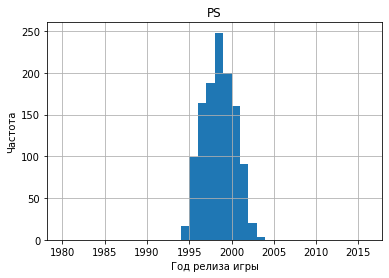

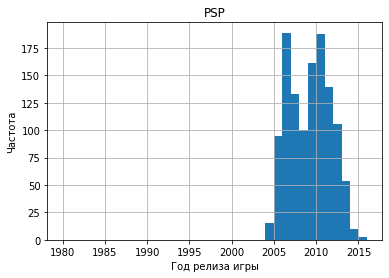

In [26]:
# цикл для построения гистограмм:
for i in range(0, len(platform_list)):
    platform_years[platform_years['platform'] == platform_list[i]].plot(kind='hist', bins = years_list, legend=False, grid=True)
    plt.title(label = platform_list[i])
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

Графики наглядно показывают поведение платформы за время ее существования.

Каков же срок жизни платформы? Попробуем ответить на этот вопрос вычислив среднюю продолжительность жизни.
Но для этого буду использовать только те платформы, продажи по которым совершенно упали. Увидеть это можно из гистограмм, построенных для всех платформ из исходного датасета. Также лучше применить медиану для оценки продолжительности жизни, т.к. есть платформы "умершие" очень быстро, в течение одного двух лет.

In [ ]:
# строим гистограммы распределения продаж для всех платформ на основании исходного датафрейма
all_platform_list = df['platform'].unique()
for i in range(0, len(all_platform_list)):
    df[df['platform'] == all_platform_list[i]].plot(kind='hist', bins=years_list, legend=False, grid=True)
    plt.title(label = all_platform_list[i])
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

In [ ]:
# исключающий список
platforms = ['PC', 'X360', 'PS3', '3DS', 'PSV', 'WiiU', 'XOne', 'PS4']
# с помощью сводной таблицы вычислим разность между годом окончания существования платформы и началом
platform_lifetime = df.pivot_table(index='platform', values='year_of_release', aggfunc=[min, max])
platform_lifetime.columns = ['beginnig', 'end']
platform_lifetime['duration'] = platform_lifetime['end'] - platform_lifetime['beginnig']

# отфильтруем полученную таблицу по списку platform_exclude
platform_lifetime_new = (platform_lifetime
                     .reset_index()
                     .query('platform not in @platforms')
                    )
platform_lifetime_new

In [ ]:
mean_lifetime = platform_lifetime_new['duration'].median()
mean_lifetime

Средний срок жизни платформы составляет 7 лет.

Чтобы определить тенденцию изменения продолжительности жизни платформ построим график.

In [ ]:
# отсортируем таблицу по годам появления на рынке платформ
platform_lifetime_x = platform_lifetime_new.sort_values(by='beginnig')['beginnig']
platform_lifetime_y = platform_lifetime_new.sort_values(by='beginnig')['duration']
plt.figure(figsize=(12,7))
plt.scatter(platform_lifetime_x, platform_lifetime_y)
# построим линию, показывающую тенденцию продолжительности жизни
z = np.polyfit(platform_lifetime_x, platform_lifetime_y, 1)
p = np.poly1d(z)
plt.plot(platform_lifetime_x,p(platform_lifetime_x))

plt.title(label='Тенденция изменения продолжительности жизни игровых платформ\n')
plt.xlabel("\nГод релиза платформы")
plt.ylabel("Продолжительность жизни платформы")
plt.show()

Как видим продолжительность жизни платформ снижается с течением времени.

Также посчитаем через сколько времени в среднем появляется новая платформа. 
Посмотрим на изменение этого параметра в расматриваемом промежутке времени.

In [ ]:
# отсортируем сгруппированную по платформам таблицу по возрастанию
platform_lifetime_up = platform_lifetime.sort_values(by='beginnig')
#platform_lifetime_up

In [ ]:
# значения столбца beginnig переведем в список
list_year_begin = list(platform_lifetime_up['beginnig'])
# создаем пустой список куда будет записываться разность в годах между релизами новых платформ
list_year_begin_difference = []

for i in range(0, len(list_year_begin)-1):
    difference = list_year_begin[i+1] - list_year_begin[i]
    list_year_begin_difference.append(difference)

# добавим последним значением NaN чтобы можно было присоединить полученные значения к датафрейму platform_lifetime_up
list_year_begin_difference.append(np.nan)
# добавляем полученные значения к датафрейму
platform_lifetime_up['difference'] = list_year_begin_difference

# удаляем строку с пропуском чтобы можно было построить график
platform_lifetime_up = platform_lifetime_up.dropna()
platform_lifetime_up

In [ ]:
# посторим точечный график рассеяния
up_x = platform_lifetime_up['beginnig']
up_y = platform_lifetime_up['difference']
plt.figure(figsize=(12,7))
plt.scatter(up_x, up_y)

plt.title(label='Тенденция изменения продолжительности жизни игровых платформ\n')
plt.xlabel("\nВремя в годах")
plt.ylabel("Время до появления новой платформы в годах")
plt.show()

In [ ]:
platform_lifetime_up['difference'].median()

Время между появлениями новых платформ сокращается. Все быстрее и быстрее появляются новые платформы.

Среднее время появления новой платформы составляет 1 год

### Потенциально прибыльные платформы

In [ ]:
#Актуальным периодом будем считать 2012 - 2016 года. Сделаем срез данных по этому периоду.
relevant_years = []
for i in range(2012, 2017):
    relevant_years.append(i)

df_relevant = df.query('year_of_release in @relevant_years')
df_relevant

In [ ]:
#Посмотрим какие платформы лидируют по суммарным продажам в этом периоде времени:
relevant_platform_sales_sum = (df_relevant
                          .pivot_table(index='platform', values='total_sales', aggfunc=sum)
                          .sort_values(by='total_sales', ascending=False)
                         )
relevant_platform_sales_sum

In [ ]:
# Построим гистограммы
for i in range(0, len(relevant_platform_sales_sum.index)):
    df_relevant[df_relevant['platform'] == relevant_platform_sales_sum.index[i]].plot(kind='hist', bins=years_list, legend=False, title=relevant_platform_sales_sum.index[i], grid=True)
    
    plt.title(label = relevant_platform_sales_sum.index[i])
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

In [ ]:
# Построим гистограммы
for i in range(0, len(relevant_platform_sales_sum.index)):
    df_relevant[df_relevant['platform'] == relevant_platform_sales_sum.index[i]].plot(kind='hist', bins=years_list, legend=False, title=relevant_platform_sales_sum.index[i], grid=True)
    
    plt.title(label = relevant_platform_sales_sum.index[i])
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

In [ ]:
# посмотрим сколько было платформ в исходном датасете
len(df['platform'].unique())

Вывод: В актуальном периоде, который мы выбрали, из 31 платформы остались только 11. Из этих 11 платформы DS и PSP можно исключить из потенциально прибыльных платформ, т.к. DS уже прекратила свое существование, а у PSP продажи практически равно нулю. Список потенциально прибыльных платформ в актуальном периоде выглядит так: relevant_platforms = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii']

### Продажи игр

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data = df_relevant, x='total_sales', y='platform')

plt.title(label='Продажи игр по платформам\n')
plt.xlabel("\nСуммарные продажи")
plt.ylabel("Платформы")
plt.xlim(0, 2.5)
plt.show()

По данным диаграммам легко определить была ли популярна платформа в интересующий нас отрезок времени. Определить можно по объему продаж, входящему в межквартильный размах и медианному значению, чем они выше тем популярнее платформа. 

Например, по графику видно, что PS4, X360 без сомнений популярны, также к популярным можно отнести XOne, Wii - они примерно на одном уровне. Наибольшая медиана у X360 из представленных платформ.

### Зависимость продаж от оценок критиков и пользователей

In [ ]:
ps4 = df_relevant.query('platform == "PS4" and (user_score != -1) and (critic_score != -1)')

# посчитаем коэффициент корреляции для отзывов пользователей и критиков относительно объема продаж
# и построим корреляционную диаграмму
for column in ['user_score', 'critic_score']:
    print(round(ps4[column].corr(ps4['total_sales']), 2))
    sns.relplot(x=column, y="total_sales", data=ps4)

In [ ]:
# Загуглила, оказалось 'PSP' уже неактуальна, а 'DS' прекратила существование, поэтому создала спиоск без этих платформ. 
#к устаревшим платформам можно отнести X360, PS3, Wii

# посчитаем коэффициент корреляции для отзывов пользователей и критиков относительно объема продаж
# и построим корреляционную диаграмму
for platform in ['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']:
    print('\n{0}:'.format(platform))
    for column in ['user_score', 'critic_score']:
        temp = df_relevant.query('platform == @platform and (user_score != -1) and (critic_score != -1)')
        print('Коэффициент корреляции {0} и total_sales: {1}'.\
              format(column, round(temp[column].corr(temp['total_sales']), 2)))
        sns.relplot(x=column, y="total_sales", data=temp)
        _ = plt.title(platform)

Заметим, что между пользовательской оценкой и продажами есть корреляция, но она небольшая, по сравнению с оценками критиков. Это логично, так как если оценки критиков у фильмов хорошие, то большое количество людей решат пойти на него, хотя не стоит недооценивать пользователей, их оценки тоже могут повлиять на продажи, хоть и не так сащественно

Исходя из графиков расеяния можно сказать, что объем продаж довольно резко возрастает при оценке критиков от 60 и выше, а до этой отметки продажи малы.

Зависимость продаж от оценок пользователей менее выраженная, но можно сказать, что продажи растут начиная с отметок в 4 балла.

Коэффициент корреляции показывает, что зависимость продаж от оценок критиков сильнее, чем от оценок пользователей.

### Распределение игр по жанрам

In [ ]:
#Рассмотрим как распределяются игры в зависимости от жанра.
#Сначала оценим количественное распределение по жанрам.
df_relevant['genre'].value_counts().plot(kind='pie', figsize=(8, 8), legend=False)

Самое больше кол-во игр в жанре Action

In [ ]:
#Посмотрим как распределяются продажи в зависимости от жанра игры.
(df_relevant
                   .pivot_table(index='genre', aggfunc={'total_sales':sum})
                   .sort_values(by='total_sales', ascending=False)
                   .plot(y='total_sales', kind='bar', figsize=(10, 5)))

Вывод: жанр Action лидирует в продажах.

In [ ]:
genre_analysis_pivot_table = df_relevant.groupby('genre').agg({'name':'count','total_sales':['median','sum']})
genre_analysis_pivot_table.columns = ['count', 'median','sum']
genre_analysis_pivot_table = genre_analysis_pivot_table.sort_values(by = 'sum', ascending = False)
genre_analysis_pivot_table

Можно заметить, что не всегда количество игр жанра гарантирует хорошие продажи, например, в жанре adventure выпущено много игр, но они имеют очень маленькое медианное значение продаж. Так же можно увидеть, что существуют обратные случаи, когда медианное значение продаж приближается к максимальному, среди всех жанров, но количество игр очень маленькое, примером может служить жанр simulation. Если рассматривать только самые прибыльные жанры, то можно заметить, что в них сочетаются два параметра, у них большое количество игр и высокое медианное значение.

## Шаг 4. Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):

-	Самые популярные платформы (топ-5). Опишите различия в долях продаж.
-	Самые популярные жанры (топ-5). Поясните разницу.
-	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Портрет пользователя

#### топ-5 платформ

In [ ]:
#Для каждого региона посчитаем суммарные продажи по платформам и определим 5 самых популярных.
top5_platforms_per_region = (df_relevant.pivot_table(index='platform', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum}))
top5_platforms_per_region

In [ ]:
#Построим графики распределения продаж по платформам оставив самые популярные.
# список регионов для цикла
region = ['eu_sales', 'na_sales', 'jp_sales']

for i in range(0, 3):
    (top5_platforms_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_platforms'))

Из графиков видно, что в Европе самая популярная платформа - PS4, в Северной Америке - X360, в Японии - 3DS.

#### топ-5 жанров

In [ ]:
#Для каждого региона посчитаем суммарные продажи по жанрам и определим 5 самых популярных.
top5_genre_per_region = (df_relevant.pivot_table(index='genre', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum}))
top5_genre_per_region

In [ ]:
for i in range(0, 3):
    (top5_genre_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_genre'))

Из графиков видно, что популярность жанров Европы и Северной Америки практически одинаковые, за исключением последнего жанра - в Европе Racing, а в Северной Америке - Misc. Жанры в Японии Role и Action лидеры в продажах с большим и резким отрывом от остальных жанров.

#### Рейтинг ESRB

In [ ]:
#посмотрим как влияет рейтинг на продажи в каждом регионе.
rating_sum = df_relevant.pivot_table(index='rating', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
rating_sum

In [ ]:
for i in range(0, 3):
    (rating_sum
     .sort_values(by=region[i], ascending=False)
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_rating'))

В Америке и Европе идентичное распределение продаж в зависимости от рейтингов: преобладают, с большим отрывом, игры c рейтингом М, далее игры с рейтингом Е, на третьем месте игры с неизвестным рейтингом, затем с рейтингом Е10+ и замыкают игры с рейтингом Т. В Японии лидируют игры с неизвестным рейтингом с большим отрывом, меньше всего популярны игры с рейтингом Е10+.

В целом можно сказать, что американцы и европейцы схожи в выборе платформ, жанров и возрастного рейтинга игр. Т.е. портреты пользователей идентичны.

Японцы сильно отличаются в предпочтениях от западных игроков.

## Шаг 5. Проверьте гипотезы

-	Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
-	Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Задайте самостоятельно пороговое значение alpha.

Поясните:

-	Как вы сформулировали нулевую и альтернативную гипотезы;
-	Какой критерий применили для проверки гипотез и почему.


#### гипотеза №1

Первая гипотеза которую нужно проверить - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы:

H0 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые(равны) (в H0 всегда используется знак равенства);
H1 - средний пользовательский рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC .
Альтернативная гипотеза у нас двусторонняя, т.к. средний рейтинг может отличаться от как в большую так и в меньшую сторону.

In [ ]:
# удалим из выборки отрицательные значения, которыми ранее заменили пропуски чтобы они не влияли на распределения
xbox_one_ttest = df_relevant[(df_relevant['platform']=='XOne')&(df_relevant['user_score'] >= 0)]['user_score']
pc_ttest = df_relevant[(df_relevant['platform']=='PC')&(df_relevant['user_score'] >= 0)]['user_score']

# проверим дисперсии рассматриваемых выборок
xbox_one_ttest_var = np.var(xbox_one_ttest, ddof=1)
pc_ttest_var = np.var(pc_ttest, ddof=1)

print('Дисперсия платформы Xbox One:', xbox_one_ttest_var)
print('Дисперсия платформы PC:', pc_ttest_var)

Разница между дисперсиями выборок довольно большая и считать дисперсии выборок равными нельзя, поэтому зададим аргумент equal_var=False.

In [ ]:
# уровень значимости 5%
alpha = 0.05

results = st.ttest_ind(xbox_one_ttest, pc_ttest, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-уровень значимости составил почти 55%, что значительно выше 5% => средний рейтинг платформ Xbox One и PC статистически значимо не отличается.
Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, может быть подтверждена, у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.

#### гипотеза №2

Вторая гипотеза - средние пользовательские рейтинги жанров Action и Sports разные.

H0 - средние пользовательские рейтинги жанров Action и Sports равны (в H0 всегда используется знак равенства);
H1 - средние пользовательские рейтинги жанров Action и Sports отличаются.
В этой гипотезе нам также нужно сравнить средние двух выборок, поэтому применим тот же тест ttest_ind.

In [ ]:
# удалим из выборки отрицательные значения, которыми ранее заменили пропуски чтобы они не влияли на распределения
action_ttest = df_relevant[(df_relevant['genre']=='Action')&(df_relevant['user_score'] >= 0)]['user_score']
sports_ttest = df_relevant[(df_relevant['genre']=='Sports')&(df_relevant['user_score'] >= 0)]['user_score']

# проверим дисперсии рассматриваемых выборок
action_ttest_var = np.var(action_ttest, ddof=1)
sports_ttest_var = np.var(sports_ttest, ddof=1)

print('Дисперсия жанра Action:', action_ttest_var)
print('Дисперсия жанра Sports:', sports_ttest_var)

Разница между дисперсиями выборок довольно большая и считать дисперсии выборок равными нельзя, поэтому зададим аргумент equal_var=False.

In [ ]:
# уровень значимости зададим равным 5%
alpha = 0.05

results = st.ttest_ind(action_ttest, sports_ttest, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-уровень значимости слишком мал, гораздо меньше определенного нами порогового значения в 5% => средние пользовательские рейтинги жанров Action и Sports статистически значимо различаются.
Альтернативная гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports отличаются, может быть подтверждена. Данные из выборок говорят о том, что скорее всего средние пользовательские рейтинги жанров Action и Sports отличаются.

## Шаг 6. Напишите общий вывод

Для нашего анализа была проведена подготовка данных:
Изменены названия столбцов, преобразованы данные в нужные типы, обработаны пропуски, были посчитаны суммарные продажи во всех регионах.

Из нашего анализа можно сделать следующий вывод:

В первую очередь обращаем внимание на прибыльные игровые платформы. Таковыми являются 'PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii'. Нужно иметь в виду, что в разных регионах популярные платформы могут отличаться, например платформа 3DS очень популярна в Японии, но менее популярна в Европе и Америке. Платформы 3DS, PS3, PS4 популярны во всех регионах.

Среди жанров видеоигр также можно выделить наиболее популярные и перспективные, например жанр Action перспективный во всех регионах, а также жанры Shooter, Sports и Role-Playing являются потенциально прибыльными. Следует быть аккуратными с таким жанром как Adventure. Несмотря на то, что игры с таким жанром занимают серьезную долю рынка в количественном отношении, их продажи маленькие.

К сожелению, очень многие игры не имеют рейтинга ESRB, поэтому данные анализа здесь не совсем полные и корректные. Но даже сейчас можно сказать, что среди игроков Европы и Северной Америки наибеолее популярны игры для взрослых и для любого возраста. В то время, как в Японии с большим отрывом лидируют игры, для которых рейтинг неустановлен.

Большое влияние на продажи игр оказывают их оценки. Оценки делятся на оценки критиков и пользователей. Мы выявили, что оценки критиков имеют в два раза более тесную связь с продажами, чем оценки пользователей. Поэтому стоит учитывать только оценки критиков. При этом нами была выявлена закономерность: продажи видеоигр начинают активно расти при оценки критиков от 60 пунктов и выше.

Пользователи из регионов Европы и Северной Америки схожи в своих предпочтених. 

Основываясь на всем вышеперечисленном, сделаем вывод, что игра имеет больше шансов на успех, если она выходит на Xbox One, а так же на платформе PS4, относится к жанру Action.